# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression of climatological fields with eddy decomposition on OMET with spatial patterns** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.10.30 ** <br>
** Last Update  : 2018.10.30 ** <br>
Description     : This notebook includes the result of the lag regression of climatological fields (e.g. z500 variance) on OMET. It aims to unveil the relation between the climatological fields and OMET and try to illustrate how the ocean drives the atmosphere through the change of OMET.
Besides, the contribution of stationary eddy and steady mean transport are studied here too.<br>
Return Values   : jpeg <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/yang/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2014
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [3]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    datapath_ORAS4_mask = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ORAS4'
    output_path = '/home/yang/NLeSC/Computation_Modeling/Bjerknes/Compensation/MET_leadlag/stat_erai_oras_layer/spatial/fields_eddy_omet'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_z500hPa_eddy = Dataset(os.path.join(datapath_ERAI_fields,
                                        'pressure_erai_subdaily_075_z500_eddies_point.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                 'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 4D fields [year, month, lat, lon]
    # geopotential height at 500hPa (m)
    z500_transient = dataset_ERAI_z500hPa_eddy.variables['transient'][:-1,:,:,:]
    z500_standing = dataset_ERAI_z500hPa_eddy.variables['standing'][:-1,:,:,:]
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:-1,:,180:]/1000
    OMET_atl_100_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_100_int'][21:-1,:,180:]/1000
    OMET_atl_300_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_300_int'][21:-1,:,180:]/1000
    OMET_atl_700_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_700_int'][21:-1,:,180:]/1000
    OMET_atl_2000_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_2000_int'][21:-1,:,180:]/1000
    
    OMET_pac_int_ORAS4 = dataset_ORAS4_OMET.variables['E_pac_int'][21:-1,:,180:]/1000  
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]    # from 1979 to 2016
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    gphiv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['gphiv'][180:,:]
    glamv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['glamv'][180:,:]
    latitude_eddy_ERAI = dataset_ERAI_z500hPa_eddy.variables['latitude'][:]
    longitude_eddy_ERAI = dataset_ERAI_z500hPa_eddy.variables['longitude'][:]
    mask_ORAS4 = dataset_ORAS4_mask.variables['vmask'][0,0,180:,:]
    # area weighted surface flux
    z500_transient_weight = np.zeros(z500_transient.shape, dtype=float) # unit W
    z500_standing_weight = np.zeros(z500_standing.shape, dtype=float)
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_eddy_ERAI /
                                            360) / len(longitude_eddy_ERAI) 
    for i in np.arange(len(latitude_eddy_ERAI)):
        # change the unit to terawatt
        z500_transient_weight[:,:,i,:] = z500_transient[:,:,i,:]* dx[i]
        z500_standing_weight[:,:,i,:] = z500_standing[:,:,i,:]* dx[i]

*********************** extract variables *************************


***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & z500 eddy transient  =====================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


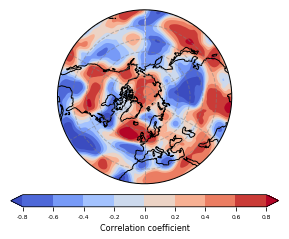

In [11]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & z500 eddy transient  =====================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    stat_z500_eddy_ERAI = meta.statistics.operator(z500_transient_weight[:])
    stat_z500_eddy_ERAI.anomaly()
    stat_z500_eddy_ERAI.detrend()
    stat_z500_eddy_ERAI.lowpass(window=120, obj='detrend')
    lag = 24
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_z500_eddy_ERAI._lowpass, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, r, p,
                                   label, ticks, os.path.join(output_path, 'eddy_transient_omet',
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_ERAI_z500_eddy_transient_decadal.png'.format(lag)))  

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & z500 eddy standing  =====================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


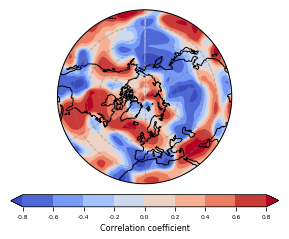

In [13]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & z500 eddy standing  =====================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    stat_z500_eddy_ERAI = meta.statistics.operator(z500_standing_weight[:])
    stat_z500_eddy_ERAI.anomaly()
    stat_z500_eddy_ERAI.detrend()
    stat_z500_eddy_ERAI.lowpass(window=120, obj='detrend')
    lag = 24
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_z500_eddy_ERAI._lowpass, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, r, p,
                                   label, ticks, os.path.join(output_path, 'eddy_standing_omet',
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_ERAI_z500_eddy_standing_decadal.png'.format(lag)))  